### 1. Import zbioru danych

In [2]:
#import bibliotek
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import ensemble
from keras import layers, models, optimizers
import numpy
import re

# załaduj zbiór danych
# __label__2 - recenzja pozytywna
# __label__1 - recenzja negatywna
# dataset https://gist.github.com/kunalj101/ad1d9c58d338e20d09ff26bcc06c4235
data = open('corpus').read()

#wypełnij listy z recenzjami i etykietami
labels, texts = [], []
for i, line in enumerate(data.split("\n")): 
    content = line.split()
    labels.append(content[0])
    texts.append(" ".join(content[1:]))

# utwórz ramkę danych
trainDF = pd.DataFrame()
# dodaj teksty do ramki danych
trainDF['text'] = texts
# dodaj etykiety do ramki danych
trainDF['label'] = labels

#wyświetl pierwszych 100 rekordów
print(trainDF.head(100))
#wyświetl informacje na temat zbioru danych
print(trainDF.describe())

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/usr/share/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/share/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/share/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dt

                                                 text       label
0   Stuning even for the non-gamer: This sound tra...  __label__2
1   The best soundtrack ever to anything.: I'm rea...  __label__2
2   Amazing!: This soundtrack is my favorite music...  __label__2
3   Excellent Soundtrack: I truly like this soundt...  __label__2
4   Remember, Pull Your Jaw Off The Floor After He...  __label__2
5   an absolute masterpiece: I am quite sure any o...  __label__2
6   Buyer beware: This is a self-published book, a...  __label__1
7   Glorious story: I loved Whisper of the wicked ...  __label__2
8   A FIVE STAR BOOK: I just finished reading Whis...  __label__2
9   Whispers of the Wicked Saints: This was a easy...  __label__2
10  The Worst!: A complete waste of time. Typograp...  __label__1
11  Great book: This was a great book,I just could...  __label__2
12  Great Read: I thought this book was brilliant,...  __label__2
13  Oh please: I guess you have to be a romance no...  __label__1
14  Awful 

### Analiza zbioru danych

In [3]:
# sprawdź liczbę słów w każdej recenzji
train = trainDF.copy()
train['word_count'] = train['text'].apply(lambda x: len(str(x).split(" ")))
print(train[['text','word_count']].head())
print(train['word_count'].max())
print(train['word_count'].min())
print(train['word_count'].mean())

                                                text  word_count
0  Stuning even for the non-gamer: This sound tra...          80
1  The best soundtrack ever to anything.: I'm rea...          97
2  Amazing!: This soundtrack is my favorite music...         129
3  Excellent Soundtrack: I truly like this soundt...         118
4  Remember, Pull Your Jaw Off The Floor After He...          87
212
14
79.5532


In [4]:
# sprawdź liczbę znaków
train['char_count'] = train['text'].str.len() ## this also includes spaces
train[['text','char_count']].head()

,text,char_count
0,Stuning even for the non-gamer: This sound tra...,426
1,The best soundtrack ever to anything.: I'm rea...,509
2,Amazing!: This soundtrack is my favorite music...,760
3,Excellent Soundtrack: I truly like this soundt...,743
4,"Remember, Pull Your Jaw Off The Floor After He...",481


In [5]:
# sprawdź średnią liczbę znaków przypadających na jedno słowo

def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

train['avg_word'] = train['text'].apply(lambda x: avg_word(x))
train[['text','avg_word']].head()

,text,avg_word
0,Stuning even for the non-gamer: This sound tra...,4.337500
1,The best soundtrack ever to anything.: I'm rea...,4.257732
2,Amazing!: This soundtrack is my favorite music...,4.899225
3,Excellent Soundtrack: I truly like this soundt...,5.305085
4,"Remember, Pull Your Jaw Off The Floor After He...",4.540230


In [6]:
# sprawdź liczbę słów ze stoplisty (popularne słowa, które nie zawierają dodatkowej informacji dla modelu)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

train['stopwords'] = train['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['text','stopwords']].head()

[nltk_data] Downloading package stopwords to /home/michal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,stopwords
0,Stuning even for the non-gamer: This sound tra...,29
1,The best soundtrack ever to anything.: I'm rea...,42
2,Amazing!: This soundtrack is my favorite music...,48
3,Excellent Soundtrack: I truly like this soundt...,33
4,"Remember, Pull Your Jaw Off The Floor After He...",28


In [7]:
# sprawdź liczbę znaków numerycznych

train['numerics'] = train['text'].apply(lambda x: len([x for x in x.split(' ') if x.isnumeric()]))
print(train[['text','numerics']].head())
print(train['numerics'].max())
print(train['numerics'].min())
print(train['numerics'].mean())

                                                text  numerics
0  Stuning even for the non-gamer: This sound tra...         0
1  The best soundtrack ever to anything.: I'm rea...         0
2  Amazing!: This soundtrack is my favorite music...         1
3  Excellent Soundtrack: I truly like this soundt...         0
4  Remember, Pull Your Jaw Off The Floor After He...         0
13
0
0.3557


In [8]:
# sprawdź liczbę wielkich liter

train['upper'] = train['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
print(train[['text','upper']].head())

train['capital'] = train['text'].apply(lambda x: len([x for x in x.split(' ') if x[0].isupper()]))
print(train['capital'].max())
print(train['capital'].min())
print(train['capital'].mean())

                                                text  upper
0  Stuning even for the non-gamer: This sound tra...      3
1  The best soundtrack ever to anything.: I'm rea...      3
2  Amazing!: This soundtrack is my favorite music...      4
3  Excellent Soundtrack: I truly like this soundt...      4
4  Remember, Pull Your Jaw Off The Floor After He...      0
179
0
11.2266


In [9]:
# sprawdź liczbę znaków interpunkcyjnych

train['punctuation'] = train['text'].apply(lambda x: len(re.findall(r'[\.,?!;:]', x)))
print(train[['text','upper']].head())

train['punctuation'] = train['text'].apply(lambda x: len([x for x in x.split(' ') if x[0].isupper()]))
print(train['punctuation'].max())
print(train['punctuation'].min())
print(train['punctuation'].mean())

                                                text  upper
0  Stuning even for the non-gamer: This sound tra...      3
1  The best soundtrack ever to anything.: I'm rea...      3
2  Amazing!: This soundtrack is my favorite music...      4
3  Excellent Soundtrack: I truly like this soundt...      4
4  Remember, Pull Your Jaw Off The Floor After He...      0
179
0
11.2266


### 2. Normalizacja tekstu

In [10]:
# ujednolicenie pisowni - zamień wielkie litery na małe

trainDFRaw = trainDF.copy()

trainDF['text'] = trainDF['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
trainDF['text'].head()

0    stuning even for the non-gamer: this sound tra...
1    the best soundtrack ever to anything.: i'm rea...
2    amazing!: this soundtrack is my favorite music...
3    excellent soundtrack: i truly like this soundt...
4    remember, pull your jaw off the floor after he...
Name: text, dtype: object

In [12]:
# usunięcie wszystkich znaków poza literami i biłymi znakami

trainDF['text'] = trainDF['text'].str.replace('[^\w\s]','')
trainDF['text'].head()

0    stuning even for the nongamer this sound track...
1    the best soundtrack ever to anything im readin...
2    amazing this soundtrack is my favorite music o...
3    excellent soundtrack i truly like this soundtr...
4    remember pull your jaw off the floor after hea...
Name: text, dtype: object

In [13]:
# usunięcie słów "stopwords"

stop = stopwords.words('english')
trainDF['text'] = trainDF['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
trainDF['text'].head()

0    stuning even nongamer sound track beautiful pa...
1    best soundtrack ever anything im reading lot r...
2    amazing soundtrack favorite music time hands i...
3    excellent soundtrack truly like soundtrack enj...
4    remember pull jaw floor hearing youve played g...
Name: text, dtype: object

In [14]:
# przygotowanie listy najczęściej wystepujących słów

freq = pd.Series(' '.join(trainDF['text']).split()).value_counts()[:20]
freq

book      6496
one       3857
like      2813
good      2769
read      2740
great     2719
movie     2543
would     2381
get       1931
time      1903
dont      1771
really    1604
first     1444
much      1419
even      1400
well      1362
story     1334
buy       1233
love      1193
best      1107
dtype: int64

In [15]:
# usunięcie słów najczęściej występujących

freq = list(freq.index)
trainDF['text'] = trainDF['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
trainDF['text'].head()

0    stuning nongamer sound track beautiful paints ...
1    soundtrack ever anything im reading lot review...
2    amazing soundtrack favorite music hands intens...
3    excellent soundtrack truly soundtrack enjoy vi...
4    remember pull jaw floor hearing youve played g...
Name: text, dtype: object

In [16]:
# przygotowanie listy słów najrzadziej występujących

freq = pd.Series(' '.join(trainDF['text']).split()).value_counts()[-20:]
freq

terrifyingly    1
unhook          1
pointer         1
nationi         1
burleigh        1
diettwo         1
trekkies        1
resurecting     1
canciones       1
wie             1
bumpkin         1
67mm            1
screed          1
desde           1
materialas      1
knocker         1
dlis            1
apartthe        1
girlshe         1
689             1
dtype: int64

In [17]:
# usuniecie słów najrzadziej wystepujących

freq = list(freq.index)
trainDF['text'] = trainDF['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
trainDF['text'].head()

0    stuning nongamer sound track beautiful paints ...
1    soundtrack ever anything im reading lot review...
2    amazing soundtrack favorite music hands intens...
3    excellent soundtrack truly soundtrack enjoy vi...
4    remember pull jaw floor hearing youve played g...
Name: text, dtype: object

In [18]:
# poprawa pisowni (literówki)

from textblob import TextBlob
trainDF['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    tuning nongamer sound track beautiful points s...
1    soundtrack ever anything in reading lot review...
2    amazing soundtrack favorite music hands intens...
3    excellent soundtrack truly soundtrack enjoy vi...
4    remember pull jaw floor hearing you played gam...
Name: text, dtype: object

In [19]:
#lematyzacja - zamiana słów ich podstawową formą

from textblob import Word
nltk.download('wordnet')

trainDF = trainDF.copy()
trainDF['text'] = trainDF['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
trainDF['text'].head()

[nltk_data] Downloading package wordnet to /home/michal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    stuning nongamer sound track beautiful paint s...
1    soundtrack ever anything im reading lot review...
2    amazing soundtrack favorite music hand intense...
3    excellent soundtrack truly soundtrack enjoy vi...
4    remember pull jaw floor hearing youve played g...
Name: text, dtype: object

### 3. Przygotowanie modelu

In [20]:
# podział zbioru danych na dane treningowe i dane testowe
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])

# kodowanie etykiet do postaci numerycznej 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

print(valid_y)

[0 1 1 ... 1 1 0]


In [21]:
# kodowanie recenzji tekstowych do formatu wektorów liczbowych TF-IDF

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)


In [22]:
# uniwersalna metoda do trenowania i oceny modeli

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # trenuj model
    classifier.fit(feature_vector_train, label)
    
    # wygeneruj przewidywania modelu dla zbioru testowego
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    # dokonaj ewaluacji modelu na podstawie danych testowych
    scores = list(metrics.precision_recall_fscore_support(predictions, valid_y))
    score_vals = [
        scores[0][0],
        scores[1][0],
        scores[2][0]
    ]
    score_vals.append(metrics.accuracy_score(predictions, valid_y))
    return score_vals

In [24]:
# MODEL 1 - regresja logistyczna 
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compare = {'LR': accuracy}
print ("LR, WordLevel TF-IDF: ", accuracy)

LR, WordLevel TF-IDF:  [0.8599527930763179, 0.8565830721003135, 0.8582646250490773, 0.8556]


In [25]:
# MODEL 2 - Support Vector Machine

accuracy = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compare['SVM'] = accuracy
print ("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  [1.0, 0.5084, 0.6740917528507027, 0.5084]


/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [26]:
# MODEL 3 - Random Forest Tree 
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compare['RF'] = accuracy
print ("RF, WordLevel TF-IDF: ", accuracy)

RF, WordLevel TF-IDF:  [0.8339889850511408, 0.7491166077738516, 0.7892777364110202, 0.7736]


In [27]:
# kodowanie słów - word embeddings

from keras.preprocessing import text, sequence

# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(trainDF['text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [28]:
# MODEL 4 - Sieć neuronowa CNN wykorzystujaca kodowanie word embeddings

def create_cnn():
    # Dodaj warstwę wejściową
    input_layer = layers.Input((70, ))

    # Dodaj warstę kodującą
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Dodaj warstwę konwolucyjną
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Dodaj warstwę łączącą
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Dodaj warstwy wyjściowe
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Skompiluj model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compare['CNN'] = accuracy
print ("CNN, Word Embeddings",  accuracy)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1
7500/7500 [==============================] - 15s 2ms/step - loss: 0.5602
CNN, Word Embeddings [1.0, 0.5084, 0.6740917528507027, 0.5084]


/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Ewaluacja modeli

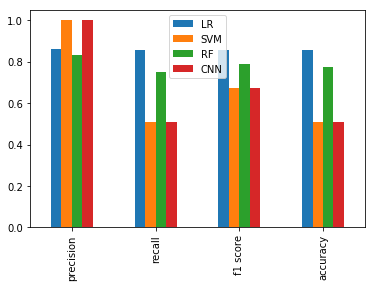

In [30]:
# porównanie modeli

df_compare = pd.DataFrame(accuracy_compare, index = ['precision', 'recall', 'f1 score', 'accuracy'])
df_compare.plot(kind='bar')

/home/rzar/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


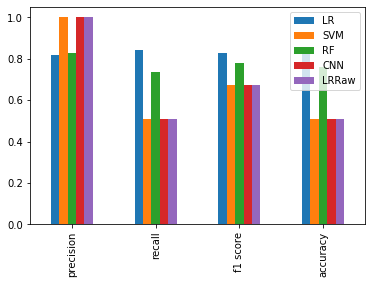

In [30]:
# bez normalizacji tekstu

# podział zbioru danych na dane treningowe i dane testowe
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDFRaw['text'], trainDFRaw['label'])

# kodowanie etykiet do postaci numerycznej 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

# kodowanie recenzji tekstowych do formatu wektorów liczbowych TF-IDF

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# MODEL 1 - regresja logistyczna 
accuracy_compare['LRRaw'] = accuracy
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)

df_compare = pd.DataFrame(accuracy_compare, index = ['precision', 'recall', 'f1 score', 'accuracy'])
df_compare.plot(kind='bar')